In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from datetime import datetime
from langgraph.graph.message import add_messages 
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from tools.car_rental import search_car_rentals, book_car_rental, update_car_rental, cancel_car_rental
from tools.excursion import search_trip_recommendations, book_excursion, update_excursion, cancel_excursion
from tools.flights import fetch_user_flight_information, search_flights, update_ticket_to_new_flight, cancel_ticket
from tools.hotels import search_hotels, book_hotel, update_hotel, cancel_hotel
from tools.policy_lookup import lookup_policy
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

In [2]:
import os
import shutil
import uuid
import time
from dotenv import load_dotenv
from populate_db import update_dates
from utils import _print_event, create_tool_node_with_fallback, handle_tool_error

load_dotenv()

True

In [3]:
class State(TypedDict):
    messages : Annotated[list, add_messages]

In [4]:
class Chatbot:
    def __init__(self, runnable: Runnable):
        self.runnable=runnable

    def __call__(self, state: State, config: RunnableConfig):
        
        while True:
            configuration = config.get("configurable", {})
            passenger_id = configuration.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
            time.sleep(1)
        return {"messages": result}

In [5]:
llm = ChatGoogleGenerativeAI(model='gemini-1.5-pro', temperature=1)

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
chatbot_runnable = primary_assistant_prompt | llm.bind_tools(tools)


In [6]:
builder = StateGraph(State)

builder.add_node("chatbot", Chatbot(chatbot_runnable))
builder.add_node('tools', ToolNode(tools))

builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

builder.add_edge("tools", "chatbot")
builder.set_entry_point('chatbot')

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

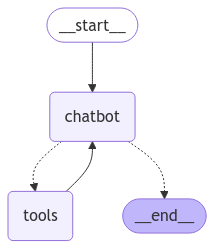

In [7]:
graph

In [8]:

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]

DB = os.getenv('DB')
db = update_dates(DB)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

Hi there, what time is my flight?


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 API key expired. Please renew the API key. [reason: "API_KEY_INVALID"
domain: "googleapis.com"
metadata {
  key: "service"
  value: "generativelanguage.googleapis.com"
}
, locale: "en-US"
message: "API key expired. Please renew the API key."
]

In [10]:
llm.invoke("hello")

AIMessage(content='How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e10dde25-c87a-4129-84ac-6520ca9b0050-0', usage_metadata={'input_tokens': 2, 'output_tokens': 8, 'total_tokens': 10, 'input_token_details': {'cache_read': 0}})